# Final Project
 * <a href="#starter">Starter Code</a>
 * <a href="#plot1">Pick Table and Plot</a>
 * <a href="#plot2">Finite Difference with Model and Plot</a>
 * <a href="#plot3">Integrate Model and Plot</a>

---
<a id='starter'></a>
## Starter Code
---

In [1]:
import sys
import requests
import json
import re
import datetime

import bs4
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np

#
# Helper Functions
#

def __guess_date(datestr):
    """
    parses strings of the form "Jan30" to python dates with year 2020
    """
    for fmt in ["%b%d", "%b %d"]:
        try:
            return datetime.datetime.strptime(datestr+"-2020", fmt+"-%Y")
        except:
            pass
    return datetime.datetime(2020, 1, 1, 0, 0)

def get_corona_data():
    """
    returns a list of dictionaries with various corona data each of the form:
    table = {
        "name": "table name",
        "title": "table title",
        "subtitle": "table subtitle",
        "x": ["Jan01", "Jan02", "Jan03", "Jan04", "Jan05"],
        "series": [
            {
                "name": "name for this line",
                "values": [1, 2, 4, 8, 16]
            }
        ]
    }
    """
    url = "https://www.worldometers.info/coronavirus/coronavirus-cases/"
    html = bs4.BeautifulSoup(requests.get(url).text, "html.parser")

    get_table = re.compile("Highcharts.chart\((.*?),(.*?)\);")
    add_quotes = re.compile("([a-zA-Z0-9]+):")
    remove_inner_quotes = re.compile("'([^'\"]*)\"?([a-zA-Z0-9]*)\"?(:?[^']*)'")
    remove_last_comma = re.compile(",\s*\]")
    remove_last_comma2 = re.compile(",\s*\}")
    tables = list()
    for tag in html.findAll("script"):
        text = tag.text
        if "Highcharts.chart(" in text:
            match = get_table.search(text.replace("\n",""))
            name = match.group(1)
            name = name.replace("'","")
            try:
                datastr = match.group(2)
                datastr = datastr.replace("d\\'Ivoire", "dIvoire")
                jstr = add_quotes.sub("\"\\1\":", datastr)
                jstr2 = remove_inner_quotes.sub("'\\1\\2\\3'", jstr)
                jstr2 = remove_inner_quotes.sub("'\\1\\2\\3'", jstr2)
                jstr2 = remove_inner_quotes.sub("\"\\1\\2\\3\"", jstr2)
                jstr2 = jstr2.replace("'", '"')
                jstr3 = remove_last_comma.sub("]", jstr2)
                jstr3 = remove_last_comma2.sub("}", jstr3)
                data = json.loads(jstr3)

                if "xAxis" not in data:
                    continue
                xdata = data["xAxis"]["categories"]
                xdata = [__guess_date(datestr) for datestr in xdata]

                series = list()
                for line in data["series"]:
                    series.append({"name":line["name"], "values":line["data"]})

                tables.append({
                    "name": name,
                    "title": data["title"]["text"],
                    "subtitle": data["subtitle"]["text"],
                    "x": xdata,
                    "series": series
                })
            except Exception as e:
                msglen = 148 - len(name)
                errmsg = str(e)
                longmsg = len(errmsg) > msglen-3
                errmsg = errmsg[:msglen]
                if longmsg:
                    errmsg = errmsg[:-3] + "..."
                print(f"warning ({name}):", errmsg, file=sys.stderr)
    return tables

# show available data tables
tables = get_corona_data()
for t in tables:
    print(f"{t['name']} - {t['title']}")
print("\n")

# pick the table with given name
TABLE_NAME = "coronavirus-cases-linear"
table = next(filter(lambda t: t["name"] == TABLE_NAME, tables))

# print some of the table data
print(table["title"])
y = table["series"][0]["values"]
print(np.array(y))

coronavirus-cases-linear - Total Cases
coronavirus - Daily New Cases
coronavirus-cases-growth - Growth Factor
coronavirus-cases-linear-outchina - Total Cases outside of China
coronavirus-cases-log-outchina - Total Cases outside of China
coronavirus-outchina - Daily New Cases outside of China
coronavirus-cases-growth-outchina - Growth Factor outside of China
graph-active-cases-total - Active Cases
graph-cured-total - Total Cured
graph-cured-daily - Daily Cured
cases-cured-daily - New Cases vs. New Recoveries
total-serious-linear - Total Serious and Critical Cases
total-serious-log - Total Serious and Critical Cases
deaths-cured-outcome - Outcome of total closed cases (recovery rate vs death rate)


Total Cases
[    580     845    1317    2015    2800    4581    6058    7813    9823
   11950   14553   17391   20630   24545   28266   31439   34876   37552
   40553   43099   45134   59287   64438   67100   69197   71329   73332
   75184   75700   76677   77673   78651   79205   80087   808

---
<a id='plot1'></a>
## Pick Table and Plot
---

plotting covid data


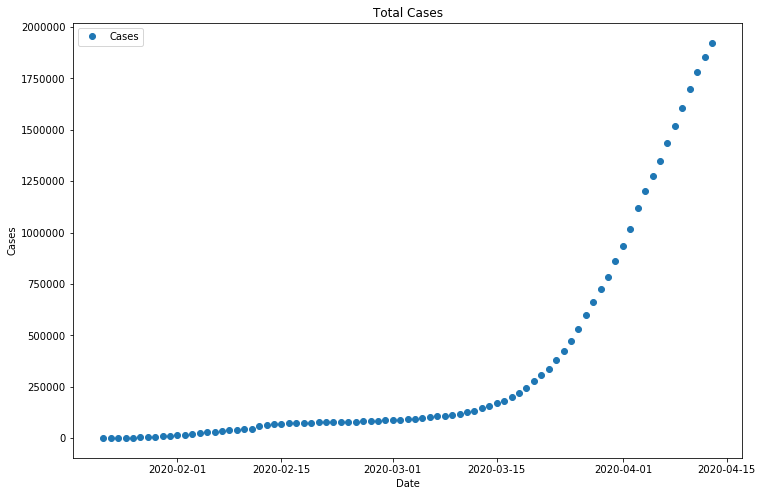

In [2]:
# get total cases data
TABLE_NAME = "coronavirus-cases-linear"
table = next(filter(lambda t: t["name"] == TABLE_NAME, tables))
series = table["series"][0]
ylabel = series["name"]
title = table["title"]
x = table["x"]
y = series["values"]

# plot data
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot_date(x, y, label=ylabel)
ax.set(title=table["title"])
ax.set(xlabel="Date")
ax.set(ylabel="Cases")
ax.legend()
print("plotting covid data")
plt.show()


---
<a id='plot2'></a>
## Finite Difference with Model and Plot
---

y = A e^(-1/2*(x-mu)^2/s^2)
A = 85878.30512722685
s = 11.707166157289212
mu = 44.385944010651244
plotting covid data derivative


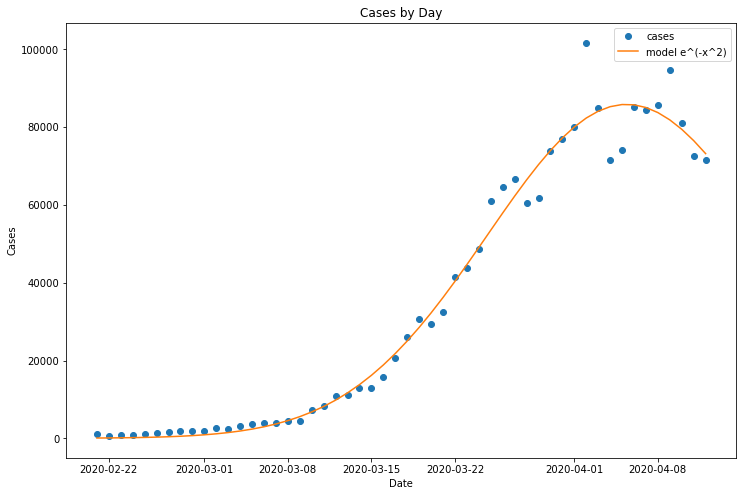

In [3]:
# calc deriv
x2 = list(x)
x2.pop()
y2 = list()
oldy = y[0]
for newy in y[1:]:
    y2.append(newy - oldy)
    oldy = newy

# fit gaussian to deriv: y = A exp( -(x-mu)^2 / (2 s^2) )
offsetx = 30
x2 = x2[offsetx:]
y2 = y2[offsetx:]
shiftx = np.array([(xx - x2[0]).days for xx in x2])
curve = lambda x,A,s,mu: A * np.exp(-0.5*np.square(x-mu)/s**2)
(A, s, mu), cov = scipy.optimize.curve_fit(curve, shiftx, y2, p0=(9e6,10,100))
fity = A * np.exp(-0.5*np.square(shiftx-mu)/s**2)
print(f"y = A e^(-1/2*(x-mu)^2/s^2)\nA = {A}\ns = {s}\nmu = {mu}")

# plot deriv with fit
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot_date(x2, y2, label="cases")
ax.plot_date(x2, fity, "-", label="model e^(-x^2)")
ax.set(title="Cases by Day")
ax.set(xlabel="Date")
ax.set(ylabel="Cases")
ax.legend()
print("plotting covid data derivative")
plt.show()


---
<a id='plot3'></a>
## Integrate Model and Plot
---

carrying capacity: 2520142.9801302557
plotting covid data with extrapolation


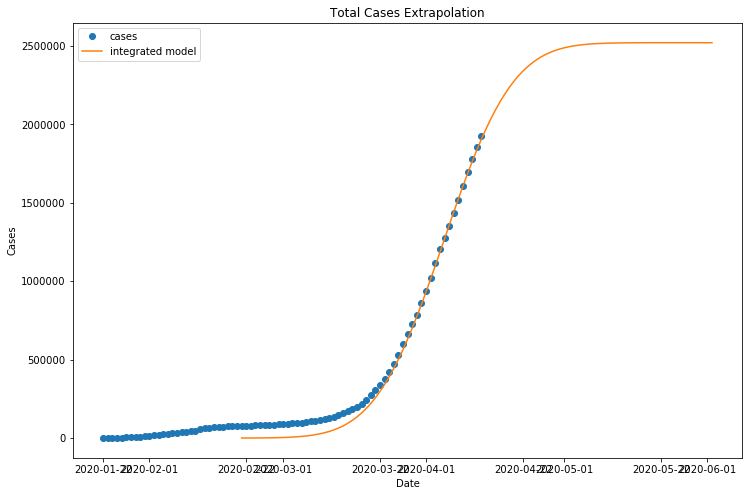

In [4]:
# plot orig with fit to future
newx2 = np.array([i for i in range(len(x) + 20)])
fity2 = A * np.exp(-0.5*np.square(newx2-mu)/s**2)
fity2 = np.cumsum(fity2)
newx = [x2[0] + datetime.timedelta(days=xx.item(0)) for xx in newx2]
cap = A*np.sqrt(2*np.pi)*s
print(f"carrying capacity: {cap}")

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot_date(x, y, label="cases")
ax.plot_date(newx, fity2, "-", label="integrated model")
ax.set(title=table["title"] + " Extrapolation")
ax.set(xlabel="Date")
ax.set(ylabel="Cases")
ax.legend()
print("plotting covid data with extrapolation")
plt.show()